## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [29]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [30]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [31]:
rows = text

In [32]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = (''.join(text)).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [33]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [34]:
# dict <index>:<char>
# Your great code here

token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here

idx_to_token = {token_to_idx[char]: char for char in token_to_idx}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

# Онегин

In [35]:
# import os


# is_here = False
# for root, dirs, files in os.walk('./'):
#     for file in files:
#         if file.endswith('onegin.txt'):
#             is_here = True

In [36]:
# if not is_here:
#     !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()

# text = [x.replace('\t\t', '') for x in text]

In [37]:
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]

# rows = text

# text = (''.join(text)).lower()

# tokens = sorted(set(text))
# num_tokens = len(tokens)

# token_to_idx = {char: index for index, char in enumerate(tokens)}

# idx_to_token = {token_to_idx[char]: char for char in token_to_idx}

# Text processing

Аналогично тому как это делалось на семинаре, предобработаем текст

In [38]:
from random import sample
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

%matplotlib inline

In [39]:
def to_matrix(rows, max_len=None, dtype='int32', batch_first = True, pad = None):
    """Casts a list of rows into rnn-digestable matrix"""
    pad = pad or token_to_idx[' ']
    max_len = max_len or max(map(len, rows))
    rows_ix = np.zeros([len(rows), max_len], dtype) + pad

    for i in range(len(rows)):
        line_ix = [token_to_idx[c] for c in rows[i]]
        rows_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        rows_ix = np.transpose(rows_ix)

    return rows_ix

In [40]:
import re

rows = [el.lower() for el in rows]
rows = [row for row in rows if len(row) > 13]
rows = [row for row in rows if len(row) < 60]

rows = [row.strip() + '\n' for row in rows]s

from fairest creatures we desire increase,



max length = 61


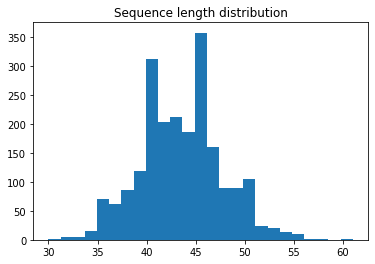

In [41]:
MAX_LENGTH = max(map(len, rows))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, rows)),bins=25);

# nn.RNN

In [42]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout=.7):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(
            input_size = emb_size,
            hidden_size = rnn_num_units,
            batch_first = True,
            num_layers = 2,
            dropout = dropout
        )
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden_state):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, hidden_state = self.rnn(self.emb(x), hidden_state)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden_state

In [43]:
model = CharRNNLoop(emb_size=32)
opt = torch.optim.Adam(model.parameters())
history = []

criterion = nn.NLLLoss()

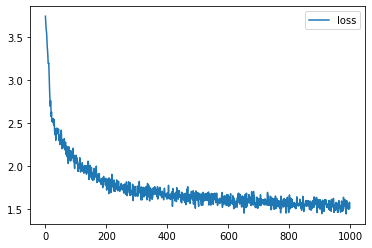

In [44]:
BATCH_SIZE = 16

for i in range(1000):
    batch_ix = to_matrix(sample(rows, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    hidden_state = torch.randn(2, BATCH_SIZE, 64)
    logp_seq = model(batch_ix, hidden_state)[0]
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [45]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_state = torch.randn(2, 1, 64)
    if len(seed_phrase) > 1:
        _, hidden_state = model(x_sequence[:, :-1], hidden_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_state = model(x_sequence[:, -1].view(1, 1), hidden_state)
        logp_next = logp_next[:, -1]
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [46]:
generate_sample(model, temperature=.6, max_length = 50)

' been, be il bold that at i the thartere a fore ee'

нуу такое...

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [47]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout=.7):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(
            input_size = emb_size,
            hidden_size = rnn_num_units,
            batch_first = True,
            num_layers = 2, 
            dropout = dropout
        )
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        assert isinstance(x.data, torch.LongTensor)
        if hidden:
            h, c = hidden
            h_seq, (h, c) = self.rnn(self.emb(x), (h, c))
        else :
            h_seq, (h, c) = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, (h, c)

In [65]:
model = CharRNNLoop(emb_size=32, rnn_num_units=128)
opt = torch.optim.Adam(model.parameters())
history = []
loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

criterion = nn.NLLLoss()

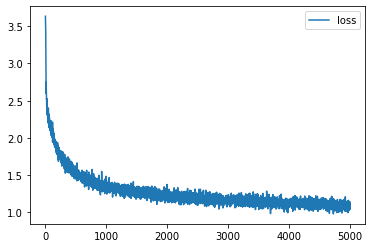

In [66]:
BATCH_SIZE = 16

for i in range(2000):
    batch_ix = to_matrix(sample(rows, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    hidden_state = torch.randn(2, BATCH_SIZE, 64)
    logp_seq, _ = model(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [67]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_state = None
    
    if len(seed_phrase) > 1:
        _, hidden_state = char_rnn(x_sequence[:, :-1])
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_state = char_rnn(x_sequence[:, -1].view(1, 1), hidden_state)
        logp_next = logp_next[:, -1]
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(num_tokens, p= p_next)
        next_ix = torch.tensor([[next_ix]], dtype = torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [68]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('T: {},  text: {}'.format(temperature, generate_sample(model, temperature=temperature, max_length=50)))

T: 0.1,  text:  have the worst the surmers of the sweet,
        
T: 0.2,  text:  have thee that i heart the should thee thee.
    
T: 0.5,  text:  had the sight the still the will of heart,
      
T: 1.0,  text:  denor that pass with thine epcits of sulle;
     
T: 2.0,  text:  igltork disneoirs'sliegh exsh how sto:-',
       


Что-то адекватное получилось при T = 0.5 и 1.0

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [69]:
torch.save(model.state_dict(), './model')

In [71]:
model = CharRNNLoop(emb_size=32, rnn_num_units=128)
model.load_state_dict(torch.load('./model'))

print(generate_sample(model, temperature=.6, max_length=200))

# вроде работает ;)

 of self pen my shate a upone thee,
                                                                                                                                                                    


###### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)